In [34]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel('erp_order_data.xlsx')
print(df.head())

   id internal_order_number online_order_number store_name  \
0   1      IO20251023000001   ON125347071883677    时代服饰旗舰店   
1   2      IO20251023000002   ON677812434302673    时代服饰旗舰店   
2   3      IO20251023000003   ON475820950373242    都市风尚官方店   
3   4      IO20251023000004   ON517267520467920    时尚潮流旗舰店   
4   5      IO20251023000005   ON262099757832742    时尚潮流旗舰店   

  full_channel_user_id           shipping_date            payment_date  \
0            U00000109 2024-12-14 04:37:51.572 2024-12-13 04:37:51.572   
1            U00000072 2025-07-09 08:35:17.042 2025-07-06 08:35:17.042   
2            U00000012 2025-02-25 05:00:55.199 2025-02-23 05:00:55.199   
3            U00000170 2025-02-10 08:35:19.627 2025-02-07 08:35:19.627   
4            U00000156 2025-06-15 10:06:56.187 2025-06-12 10:06:56.187   

   payable_amount  paid_amount status  ... unit_price product_name  \
0          525.78       525.78    已完成  ...     257.89        修身牛仔裤   
1          157.10       157.10    已完成  ...

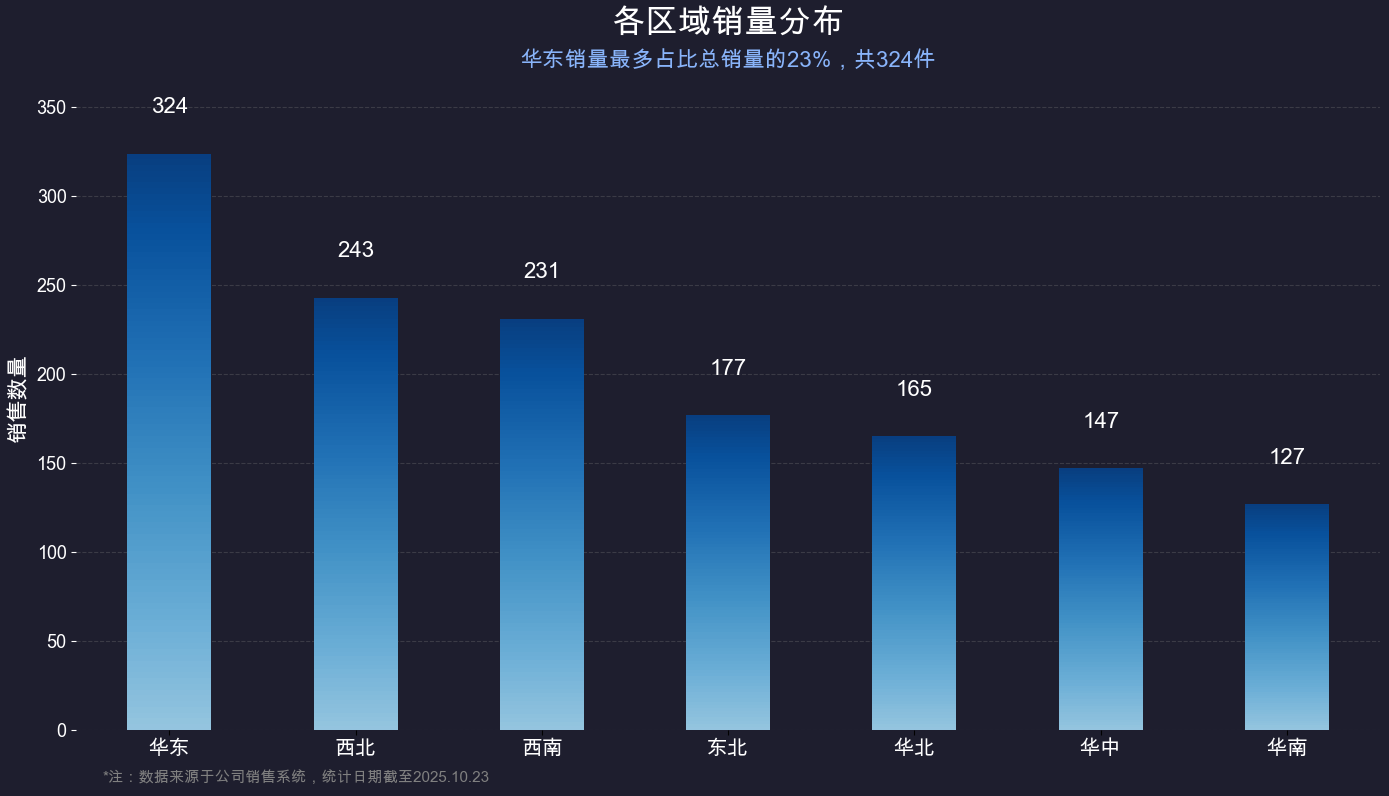


各区域销量统计：
region  total_quantity  order_count
    华东             324          178
    西北             243          152
    西南             231          128
    东北             177          109
    华北             165           94
    华中             147           94
    华南             127           75

总销量：1414 件
订单总数：1000 单


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti']
plt.rcParams['axes.unicode_minus'] = False

# 定义区域映射（根据中国地理区域划分）
region_mapping = {
    '北京': '华北', '天津': '华北', '河北省': '华北', '山西省': '华北', '内蒙古自治区': '华北',
    '辽宁省': '东北', '吉林省': '东北', '黑龙江省': '东北',
    '上海': '华东', '江苏省': '华东', '浙江省': '华东', '安徽省': '华东', '福建省': '华东', 
    '江西省': '华东', '山东省': '华东',
    '河南省': '华中', '湖北省': '华中', '湖南省': '华中',
    '广东省': '华南', '广西壮族自治区': '华南', '海南省': '华南',
    '重庆': '西南', '四川省': '西南', '贵州省': '西南', '云南省': '西南', '西藏自治区': '西南',
    '陕西省': '西北', '甘肃省': '西北', '青海省': '西北', '宁夏回族自治区': '西北', '新疆维吾尔自治区': '西北'
}

# 添加区域列
df['region'] = df['province'].map(region_mapping)

# 按区域统计订单数量
region_stats = df.groupby('region').agg({
    'quantity': 'sum',
    'id': 'count'
}).reset_index()
region_stats.columns = ['region', 'total_quantity', 'order_count']

# 按总数量排序
region_stats = region_stats.sort_values('total_quantity', ascending=False)

# 创建图表
fig, ax = plt.subplots(figsize=(14, 8))

# 设置深色背景
fig.patch.set_facecolor('#1e1e2e')
ax.set_facecolor('#1e1e2e')

# 获取数据
regions = region_stats['region'].tolist()
quantities = region_stats['total_quantity'].tolist()

# 绘制渐变柱形图
bar_width = 0.45  # 缩小柱子宽度
gradient_steps = 100  # 渐变层数

# 获取colormap
cmap = mpl.colormaps.get_cmap('Blues')

for i, (region, qty) in enumerate(zip(regions, quantities)):
    # 为每个柱子创建从下到上的渐变效果
    for j in range(gradient_steps):
        # 计算每一层的高度和位置
        layer_height = qty / gradient_steps
        y_position = j * layer_height
        
        # 从0.4到0.95的渐变（从浅蓝到深蓝）
        color_value = 0.4 + (j / gradient_steps) * 0.55
        color = cmap(color_value)
        
        # 绘制每一层的矩形（无边框）
        rect = Rectangle((i - bar_width/2, y_position), bar_width, layer_height,
                         facecolor=color, edgecolor='none')
        ax.add_patch(rect)
    
    # 在柱子上添加数值标签
    ax.text(i, qty + 20, f'{int(qty)}',
            ha='center', va='bottom', fontsize=16, fontweight='bold', color='white')

# 设置x轴
ax.set_xticks(range(len(regions)))
ax.set_xticklabels(regions, fontsize=15, color='white')
ax.set_xlim(-0.5, len(regions) - 0.5)

# 设置y轴
ax.set_ylim(0, max(quantities) * 1.15)
ax.set_ylabel('销售数量', fontsize=16, fontweight='bold', color='white')
ax.tick_params(axis='y', colors='white', labelsize=13)

# 设置网格线（仅保留横向虚线）
ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray', zorder=0)
ax.set_axisbelow(True)

# 隐藏所有边框
for spine in ax.spines.values():
    spine.set_visible(False)

# 添加标题和注释
total_qty = region_stats['total_quantity'].sum()
max_region = region_stats.iloc[0]
percentage = (max_region['total_quantity'] / total_qty * 100)

title_text = f'各区域销量分布'
subtitle_text = f'{max_region["region"]}销量最多占比总销量的{percentage:.0f}%，共{int(max_region["total_quantity"])}件'

ax.text(0.5, 1.05, title_text, 
        transform=ax.transAxes, fontsize=24, fontweight='bold', 
        ha='center', color='white')
ax.text(0.5, 1.00, subtitle_text,
        transform=ax.transAxes, fontsize=16,
        ha='center', color='#89b4fa')

# 添加数据来源注释
ax.text(0.02, -0.08, '*注：数据来源于公司销售系统，统计日期截至2025.10.23',
        transform=ax.transAxes, fontsize=11, color='gray', style='italic')

plt.tight_layout()
plt.show()

print(f"\n各区域销量统计：")
print(region_stats.to_string(index=False))
print(f"\n总销量：{total_qty} 件")
print(f"订单总数：{df['id'].nunique()} 单")

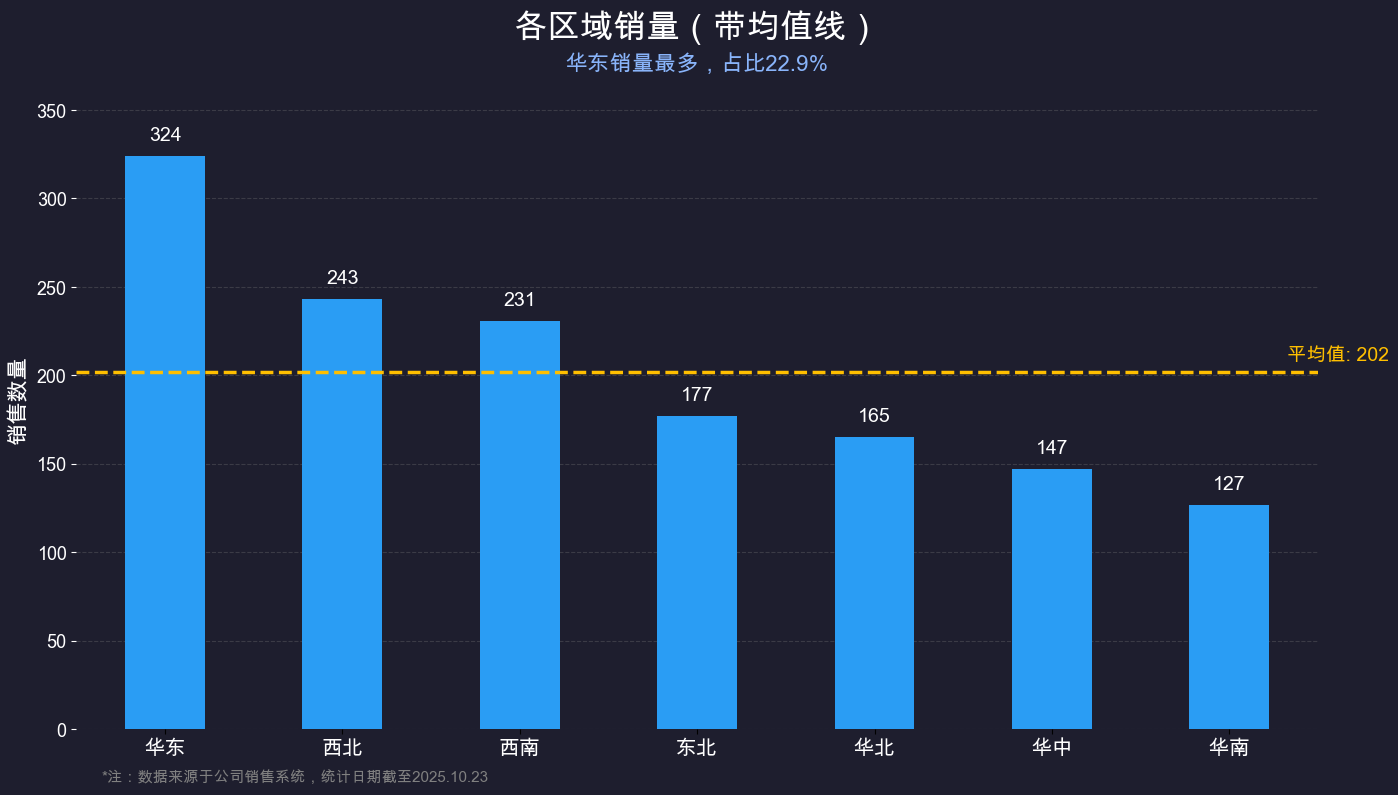


各区域销量统计：
region  total_quantity  order_count
    华东             324          178
    西北             243          152
    西南             231          128
    东北             177          109
    华北             165           94
    华中             147           94
    华南             127           75

平均销量: 202.00 件


In [ ]:
# 可复用单元：绘制区域销量柱状图并标注均值（假设 cell 3 已计算并存在 region_stats）
import matplotlib.pyplot as plt
import numpy as np

def plot_region_bar_with_mean(region_stats, figsize=(12,6), bar_color='#2a9df4'):
    """绘制按区域的柱状图并标注均值线。
    输入：region_stats DataFrame (columns: region, total_quantity, order_count)
    """
    regions = region_stats['region'].tolist()
    quantities = region_stats['total_quantity'].tolist()
    x = np.arange(len(regions))

    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('#1e1e2e')
    ax.set_facecolor('#1e1e2e')

    # 柱状图
    bars = ax.bar(x, quantities, color=bar_color, width=0.45, zorder=3)

    # 在柱子上显示数值标签
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + max(quantities) * 0.02,
                f'{int(h)}', ha='center', va='bottom', fontsize=14, color='white', fontweight='bold')

    # 平均值线
    mean_val = np.mean(quantities)
    ax.axhline(mean_val, color='#ffbf00', linestyle='--', linewidth=2.5, zorder=4)
    ax.text(len(regions) - 0.1, mean_val + max(quantities) * 0.02,
            f'平均值: {mean_val:.0f}', color='#ffbf00', fontsize=14, fontweight='bold', ha='right')

    # 坐标轴和样式
    ax.set_xticks(x)
    ax.set_xticklabels(regions, fontsize=15, color='white')
    ax.set_xlim(-0.5, len(regions) - 0.5)
    ax.set_ylim(0, max(quantities) * 1.15)
    ax.set_ylabel('销售数量', fontsize=16, fontweight='bold', color='white')
    ax.tick_params(axis='y', colors='white', labelsize=13)

    # 仅保留横向虚线网格
    ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray', zorder=0)
    ax.set_axisbelow(True)

    # 隐藏外框
    for spine in ax.spines.values():
        spine.set_visible(False)

    # 标题与副标题
    title_text = '各区域销量（带均值线）'
    subtitle_text = f'{region_stats.iloc[0]["region"]}销量最多，占比{region_stats.iloc[0]["total_quantity"] / region_stats["total_quantity"].sum() * 100:.1f}%'
    ax.text(0.5, 1.05, title_text, transform=ax.transAxes, fontsize=24, fontweight='bold', ha='center', color='white')
    ax.text(0.5, 1.00, subtitle_text, transform=ax.transAxes, fontsize=16, ha='center', color='#89b4fa')

    # 注释
    ax.text(0.02, -0.08, '*注：数据来源于公司销售系统，统计日期截至2025.10.23', transform=ax.transAxes, fontsize=11, color='gray', style='italic')

    plt.tight_layout()
    plt.show()

    # 返回均值以便后续使用
    return mean_val

mean_value = plot_region_bar_with_mean(region_stats, figsize=(14,8))
print('\n各区域销量统计：')
print(region_stats.to_string(index=False))
print(f'\n平均销量: {mean_value:.2f} 件')


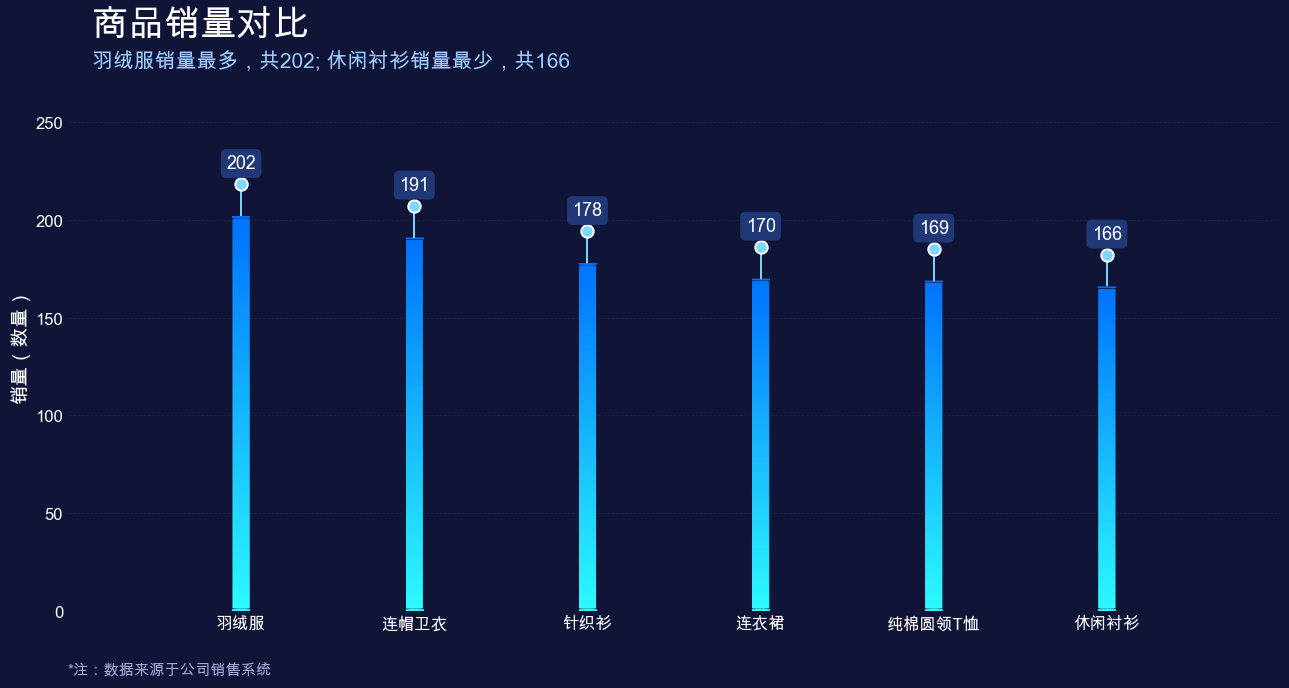


商品销量统计（Top）:
product_name  quantity
         羽绒服       202
        连帽卫衣       191
         针织衫       178
         连衣裙       170
      纯棉圆领T恤       169
        休闲衬衫       166


In [65]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# 参数设置
target_month = 3  # 需要展示的月份（1-12），若无月份数据会自动展示全部
top_n = 6        # 展示Top N 商品

df_products = df.copy()
month_label = f"{target_month}月"
note_date = None

if 'order_date' in df_products.columns:
    df_products['order_date'] = pd.to_datetime(df_products['order_date'], errors='coerce')
    month_data = df_products[df_products['order_date'].dt.month == target_month]
    if not month_data.empty:
        df_products = month_data
        note_date = month_data['order_date'].max()
    else:
        note_date = df_products['order_date'].max()
        month_label = ''  # 若对应月份没有数据，则退回全部数据
else:
    month_label = ''

if df_products.empty:
    raise ValueError('没有可用的商品销量数据用于绘图，请检查数据源。')

product_stats = (
    df_products.groupby('product_name', as_index=False)['quantity']
    .sum()
    .sort_values('quantity', ascending=False)
    .head(top_n)
 )

if product_stats.empty:
    raise ValueError('商品统计结果为空，请确认字段 "product_name" 和 "quantity" 是否存在。')

names = product_stats['product_name'].tolist()
values = product_stats['quantity'].tolist()
max_val = max(values)

top_name = product_stats.iloc[0]['product_name']
top_qty = int(product_stats.iloc[0]['quantity'])
bottom_name = product_stats.iloc[-1]['product_name']
bottom_qty = int(product_stats.iloc[-1]['quantity'])

title_text = f"{month_label}商品销量对比" if month_label else "商品销量对比"
if month_label:
    subtitle_text = f"{top_name}销量最多，{month_label}销量{top_qty}; {bottom_name}最少，{month_label}销量{bottom_qty}"
else:
    subtitle_text = f"{top_name}销量最多，共{top_qty}; {bottom_name}销量最少，共{bottom_qty}"

bg_color = '#101538'
grid_color = '#2c3c66'
dot_color = '#7dd8ff'
value_bg = '#233c7c'

fig, ax = plt.subplots(figsize=(13, 7))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

cmap = LinearSegmentedColormap.from_list('cyan_blue', ['#2efbff', '#0072ff'])
bar_width = 0.05
bar_spacing = 0.5  # <1 会减少柱子之间的间距
gradient_steps = 256
gradient_template = np.linspace(0, 1, gradient_steps).reshape(gradient_steps, 1)

x = np.arange(len(names)) * bar_spacing  # 使用 numpy 精准控制柱子位置并缩小间距
bars = ax.bar(x, values, width=bar_width, color='none', edgecolor='none', zorder=2)

def bar_rounding(height):
    return np.clip(height * 0.02, bar_width * 6, bar_width * 28)

for bar, val in zip(bars, values):
    left = bar.get_x()
    rounding = bar_rounding(val)
    patch = FancyBboxPatch((left, 0), bar_width, val,
                            boxstyle=f'round,pad=0,rounding_size={rounding}',
                            linewidth=0, facecolor='none', edgecolor='none', zorder=4)
    ax.add_patch(patch)
    img = ax.imshow(gradient_template, extent=(left, left + bar_width, 0, val), origin='lower',
                    aspect='auto', cmap=cmap, zorder=3, interpolation='bicubic')
    img.set_clip_path(patch)

stem_height = max_val * 0.08
label_offset = max_val * 0.03

ax.vlines(x, values, np.array(values) + stem_height, colors=dot_color, linewidth=1.4, zorder=5)
ax.scatter(x, np.array(values) + stem_height, s=80, color=dot_color, edgecolors='white', linewidth=1.4, zorder=6)

for xi, val in zip(x, values):
    ax.text(xi, val + stem_height + label_offset, f"{int(val)}",
            ha='center', va='bottom', fontsize=13, color='white', fontweight='bold', zorder=7,
            bbox=dict(boxstyle='round,pad=0.3', facecolor=value_bg, edgecolor='none', alpha=0.92))

ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=13, color='white')
pad = max(bar_width * 3, bar_spacing)
if len(x) > 0:
    x_min, x_max = float(np.min(x)), float(np.max(x))
else:
    x_min, x_max = 0.0, 0.0
ax.set_xlim(x_min - pad, x_max + pad)
ax.set_ylim(0, max_val * 1.35)
ax.set_ylabel('销量（数量）', fontsize=14, color='white')
ax.tick_params(axis='both', colors='white', labelsize=12, width=0.8, length=0)
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', color=grid_color, alpha=0.35, linewidth=0.6)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.text(0.02, 1.08, title_text, transform=ax.transAxes, fontsize=26, fontweight='bold',
        ha='left', color='white')
ax.text(0.02, 1.02, subtitle_text, transform=ax.transAxes, fontsize=15,
        ha='left', color='#9acbff')

note_text = '*注：数据来源于公司销售系统'
if note_date is not None and pd.notna(note_date):
    note_text += f"，统计日期截至{note_date.strftime('%Y.%m.%d')}"
ax.text(0.0, -0.12, note_text, transform=ax.transAxes, fontsize=11, color='#9fa9d8', style='italic')

plt.tight_layout()
plt.show()

print('\n商品销量统计（Top）:')
print(product_stats.to_string(index=False))

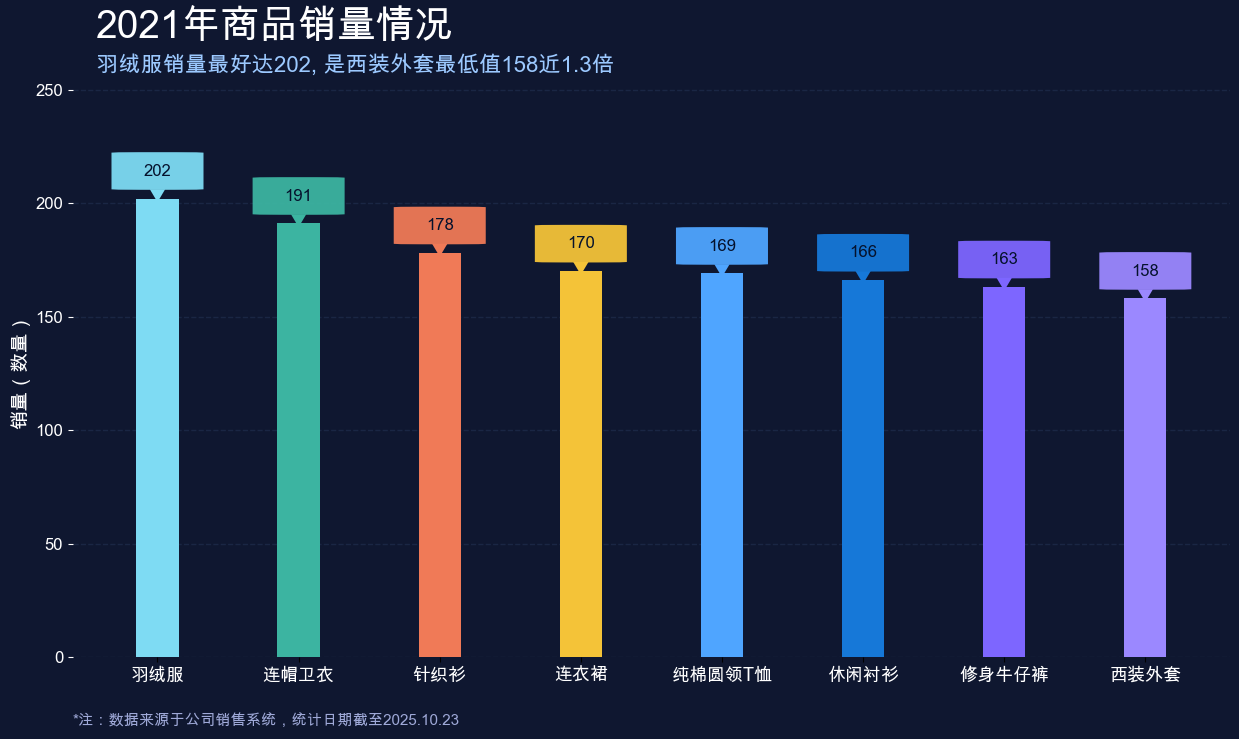

In [36]:
#多色标注柱形图
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Polygon

top_n = 8
category_stats = (
    df.groupby('product_name', as_index=False)['quantity']
    .sum()
    .sort_values('quantity', ascending=False)
    .head(top_n)
 )


names = category_stats['product_name'].tolist()
values = category_stats['quantity'].tolist()
x = np.arange(len(names))
max_val = max(values)

palette = ['#7edbf3', '#3cb4a1', '#f07a57', '#f4c338', '#4fa5ff', '#1678d8', '#7d66ff', '#9b88ff']
if len(palette) < len(names):
    repeats = int(np.ceil(len(names) / len(palette)))
    palette = (palette * repeats)[:len(names)]

bg_color = '#0f1730'
grid_color = '#2b3f63'
title_text = '2021年商品销量情况'
subtitle_text = f"{names[0]}销量最好达{values[0]}, 是{names[-1]}最低值{values[-1]}近{values[0] / values[-1]:.1f}倍"
note_text = '*注：数据来源于公司销售系统，统计日期截至2025.10.23'

fig, ax = plt.subplots(figsize=(12.5, 7.5))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

bar_width = 0.3
bars = ax.bar(x, values, color=palette[:len(names)], width=bar_width, edgecolor='none', zorder=2)

gap = max_val * 0.02
label_height = max_val * 0.08
triangle_half = bar_width * 0.18

for xi, val, color in zip(x, values, palette):
    rect = FancyBboxPatch((xi - bar_width * 0.42, val + gap),
                          bar_width * 0.84, label_height,
                          boxstyle='round,pad=0.2',
                          facecolor=color, edgecolor='none', zorder=4, alpha=0.95)
    ax.add_patch(rect)
    pointer = Polygon([[xi - triangle_half, val + gap],
                       [xi + triangle_half, val + gap],
                       [xi, val + gap - label_height * 0.35]],
                      closed=True, facecolor=color, edgecolor='none', zorder=3)
    ax.add_patch(pointer)
    ax.text(xi, val + gap + label_height / 2, f"{int(val)}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            color='#05122d', zorder=5)

ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=13, color='white')
ax.set_ylim(0, max_val * 1.25)
ax.set_xlim(-0.6, len(names) - 0.4)
ax.set_ylabel('销量（数量）', fontsize=14, color='white')
ax.tick_params(axis='y', colors='white', labelsize=12)
ax.yaxis.grid(True, linestyle='--', color=grid_color, alpha=0.4, linewidth=1, zorder=1)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.text(0.02, 1.08, title_text, transform=ax.transAxes, fontsize=28, fontweight='bold',
        ha='left', color='white')
ax.text(0.02, 1.02, subtitle_text, transform=ax.transAxes, fontsize=16,
        ha='left', color='#9cc9ff')
ax.text(0.0, -0.12, note_text, transform=ax.transAxes, fontsize=11,
        color='#9fa9d8', style='italic')

plt.tight_layout()
plt.show()

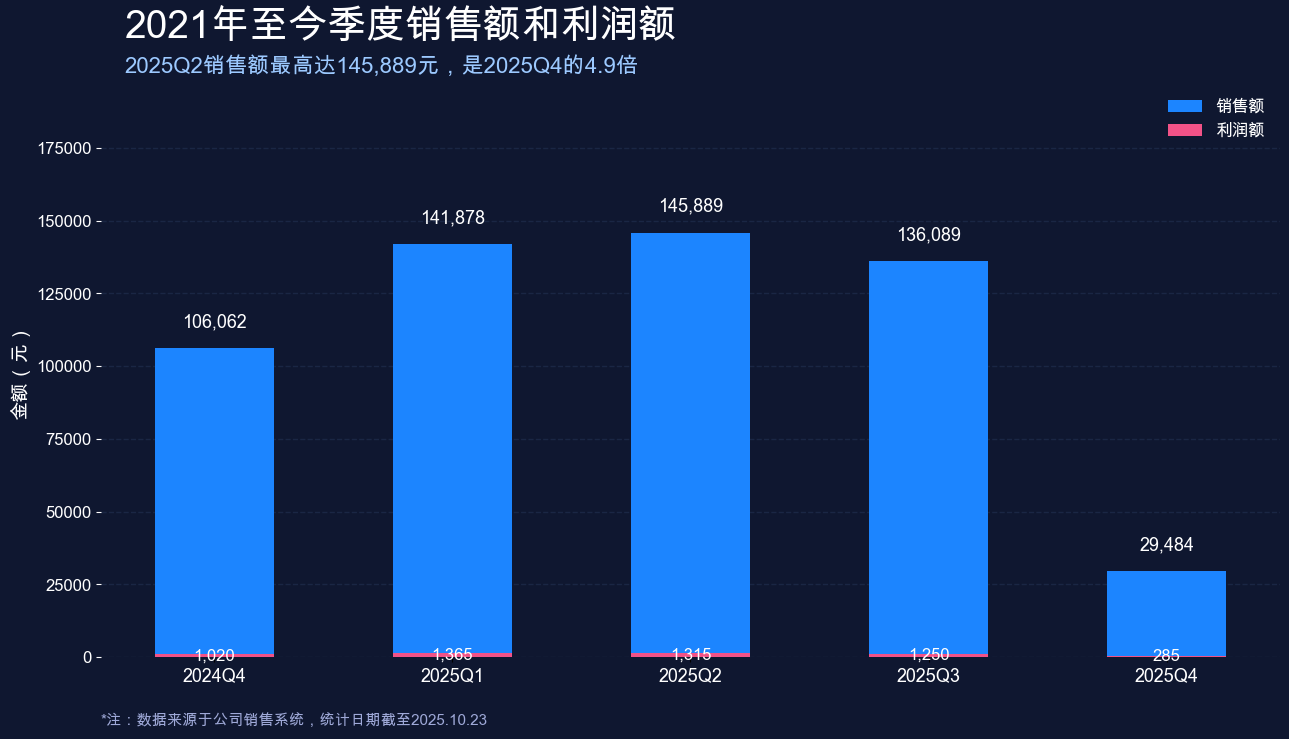

In [37]:
# 层叠柱形图：季度销售额和利润额（实际数值）
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df_quarter = df.copy()
required_columns = {'payment_date', 'paid_amount'}
missing = required_columns - set(df_quarter.columns)
if missing:
    raise ValueError(f'缺少字段：{missing}，无法计算季度销售额。')

df_quarter['payment_date'] = pd.to_datetime(df_quarter['payment_date'], errors='coerce')
df_quarter = df_quarter.dropna(subset=['payment_date'])

if 'product_amount' not in df_quarter.columns:
    if {'unit_price', 'quantity'}.issubset(df_quarter.columns):
        df_quarter['product_amount'] = df_quarter['unit_price'] * df_quarter['quantity']
    else:
        raise ValueError('缺少 "product_amount" 字段，无法估算利润。')

df_quarter['quarter_period'] = df_quarter['payment_date'].dt.to_period('Q')
agg = df_quarter.groupby('quarter_period').agg(
    sales_amount=('paid_amount', 'sum'),
    cost_amount=('product_amount', 'sum')
).reset_index()
agg['profit_amount'] = (agg['sales_amount'] - agg['cost_amount']).clip(lower=0)
agg = agg.sort_values('quarter_period')
agg['quarter_label'] = agg['quarter_period'].astype(str)

recent_quarters = 6
if len(agg) > recent_quarters:
    agg = agg.tail(recent_quarters).reset_index(drop=True)

if agg.empty:
    raise ValueError('季度汇总结果为空，请检查日期或金额字段。')

sales = agg['sales_amount'].to_numpy()
profit = agg['profit_amount'].to_numpy()
non_profit = np.clip(sales - profit, a_min=0, a_max=None)

quarters = agg['quarter_label'].tolist()
x = np.arange(len(quarters))

bg_color = '#0f1730'
grid_color = '#2b3f63'
sales_color = '#1c85ff'
profit_color = '#f25287'

fig, ax = plt.subplots(figsize=(13, 7.5))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

bar_width = 0.5
profit_bars = ax.bar(x, profit, width=bar_width, color=profit_color, edgecolor='none', zorder=2)
sales_bars = ax.bar(x, non_profit, width=bar_width, bottom=profit, color=sales_color, edgecolor='none', zorder=3)

max_total = sales.max()
label_offset = max_total * 0.04

for xi, total, pr in zip(x, sales, profit):
    if pr > 0:
        ax.text(xi, pr / 2, f"{pr:,.0f}", color='white', fontsize=12, fontweight='bold', ha='center', va='center')
    ax.text(xi, total + label_offset, f"{total:,.0f}", color='white', fontsize=13, fontweight='bold', ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(quarters, fontsize=13, color='white')
ax.set_ylim(0, max_total * 1.35)
ax.set_ylabel('金额（元）', fontsize=14, color='white')
ax.tick_params(axis='y', colors='white', labelsize=12)
ax.yaxis.grid(True, linestyle='--', color=grid_color, alpha=0.4, linewidth=1, zorder=1)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

legend_elements = [
    Patch(facecolor=sales_color, edgecolor='none', label='销售额'),
    Patch(facecolor=profit_color, edgecolor='none', label='利润额')
 ]
legend = ax.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)
for text in legend.get_texts():
    text.set_color('white')

top_row = agg.loc[sales.argmax()]
bottom_row = agg.loc[sales.argmin()]
ratio = (top_row['sales_amount'] / bottom_row['sales_amount']) if bottom_row['sales_amount'] else np.nan
subtitle_text = f"{top_row['quarter_label']}销售额最高达{top_row['sales_amount']:,.0f}元"
if np.isfinite(ratio) and ratio > 0:
    subtitle_text += f"，是{bottom_row['quarter_label']}的{ratio:.1f}倍"
note_date = df_quarter['payment_date'].max()
note_text = '*注：数据来源于公司销售系统'
if pd.notna(note_date):
    note_text += f"，统计日期截至{note_date.strftime('%Y.%m.%d')}"

ax.text(0.02, 1.08, '2021年至今季度销售额和利润额', transform=ax.transAxes, fontsize=28, fontweight='bold', ha='left', color='white')
ax.text(0.02, 1.02, subtitle_text, transform=ax.transAxes, fontsize=16, ha='left', color='#9cc9ff')
ax.text(0.0, -0.12, note_text, transform=ax.transAxes, fontsize=11, color='#9fa9d8', style='italic')

plt.tight_layout()
plt.show()

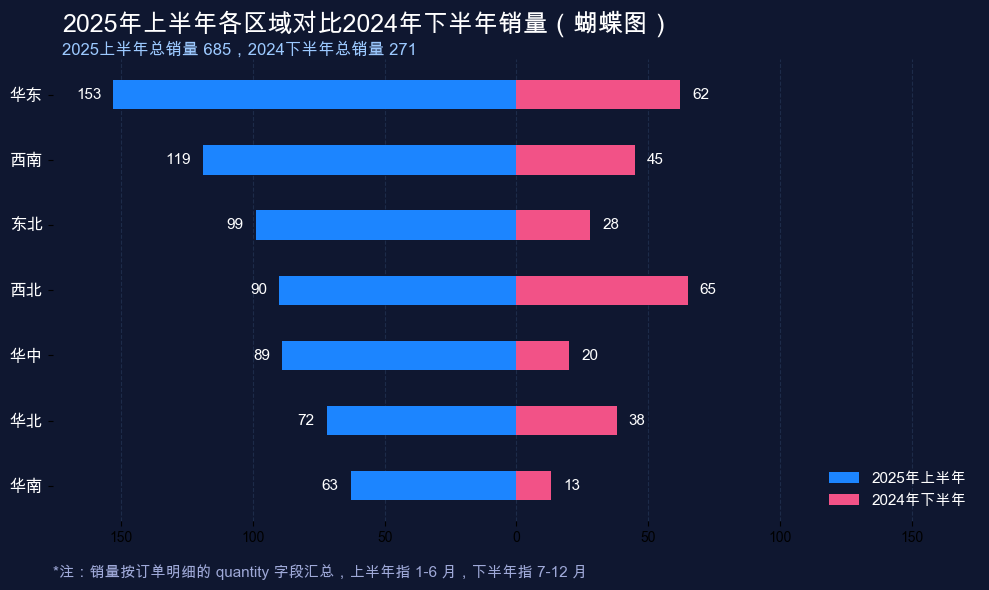

In [38]:
# 蝴蝶图：2025年上半年各区域对比2024年下半年销量
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# 检查销量字段与时间字段
if 'quantity' not in df.columns:
    raise ValueError('缺少字段 "quantity"，无法计算销量。')
if 'payment_date' not in df.columns:
    raise ValueError('缺少字段 "payment_date"，无法按时间过滤。')

df['payment_date'] = pd.to_datetime(df['payment_date'], errors='coerce')
df_time = df.dropna(subset=['payment_date']).copy()

# 选择区间：2025 上半年（1-6 月） vs 2024 下半年（7-12 月）
h1_2025 = df_time[(df_time['payment_date'].dt.year == 2025) & (df_time['payment_date'].dt.month <= 6)]
h2_2024 = df_time[(df_time['payment_date'].dt.year == 2024) & (df_time['payment_date'].dt.month >= 7)]

agg25 = h1_2025.groupby('region', as_index=True)['quantity'].sum().rename('sales_2025')
agg24 = h2_2024.groupby('region', as_index=True)['quantity'].sum().rename('sales_2024')

comp = pd.concat([agg25, agg24], axis=1).fillna(0)
# 按 2025 销量降序展示（便于对比）
comp = comp.sort_values('sales_2025', ascending=False)
if comp.empty:
    raise ValueError('没有找到 2025 H1 或 2024 H2 的区域销量，请检查数据范围/字段。')

regions = comp.index.tolist()
sales25 = comp['sales_2025'].values
sales24 = comp['sales_2024'].values

# 蝴蝶图准备：左侧显示 2025（取负），右侧显示 2024 下半年
left = -sales25
right = sales24
y = np.arange(len(regions))

# 画图样式
bg = '#0f1730'
left_color = '#1c85ff'   # 2025（蓝）
right_color = '#f25287'  # 2024（粉）
grid_color = '#2b3f63'

fig, ax = plt.subplots(figsize=(10, max(6, len(regions)*0.6)))
fig.patch.set_facecolor(bg)
ax.set_facecolor(bg)

bar_height = 0.45
ax.barh(y, left, height=bar_height, color=left_color, zorder=3)
ax.barh(y, right, height=bar_height, color=right_color, zorder=3)

# 单侧数值标签（显示绝对值）
max_val = max(sales25.max() if len(sales25)>0 else 0, sales24.max() if len(sales24)>0 else 0)
pad = max_val * 0.03 if max_val>0 else 1

for yi, a, b in zip(y, left, right):
    # 左侧（2025）标签
    ax.text(a - pad, yi, f"{int(abs(a)):,.0f}", ha='right', va='center', color='white', fontsize=11, fontweight='bold')
    # 右侧（2024 H2）标签
    ax.text(b + pad, yi, f"{int(b):,.0f}", ha='left', va='center', color='white', fontsize=11, fontweight='bold')

# y 轴显示区域名
ax.set_yticks(y)
ax.set_yticklabels(regions, fontsize=12, color='white')

# x 轴格式化为绝对值显示
def fmt(x, pos):
    return f"{int(abs(x)):,.0f}"
ax.xaxis.set_major_formatter(FuncFormatter(fmt))

# 对称 xlim
ax.set_xlim(-max_val*1.15, max_val*1.15)

# 样式调整
ax.invert_yaxis()  # 使排行靠上
ax.xaxis.grid(True, linestyle='--', color=grid_color, alpha=0.5, zorder=0)
for spine in ax.spines.values():
    spine.set_visible(False)

# 图例与标题
from matplotlib.patches import Patch
legend = ax.legend([Patch(facecolor=left_color), Patch(facecolor=right_color)], ['2025年上半年','2024年下半年'], loc='lower right', frameon=False, fontsize=11)
for t in legend.get_texts():
    t.set_color('white')

total25 = int(sales25.sum())
total24 = int(sales24.sum())
subtitle = f"2025上半年总销量 {total25:,d}，2024下半年总销量 {total24:,d}"
ax.text(0.01, 1.06, '2025年上半年各区域对比2024年下半年销量（蝴蝶图）', transform=ax.transAxes, fontsize=18, fontweight='bold', ha='left', color='white')
ax.text(0.01, 1.01, subtitle, transform=ax.transAxes, fontsize=12, ha='left', color='#9cc9ff')

note_text = '*注：销量按订单明细的 quantity 字段汇总，上半年指 1-6 月，下半年指 7-12 月'
ax.text(0.0, -0.12, note_text, transform=ax.transAxes, fontsize=11, color='#9fa9d8', style='italic')

plt.tight_layout()
plt.show()

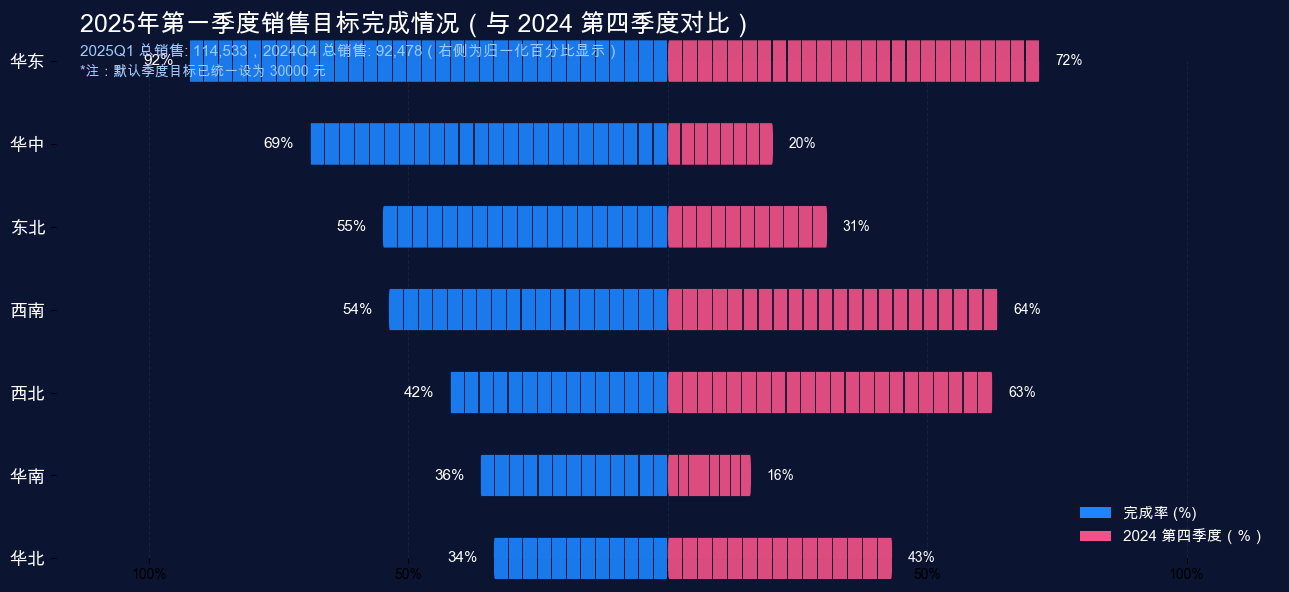

In [58]:
# 2025年第一季度销售目标完成情况（蝴蝶图样式）——美化与默认季度目标统一为 40000 元
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle, Patch
from matplotlib.ticker import FuncFormatter

# 准备数据：按区域汇总 2025 Q1 的销售额（优先使用 paid_amount，否则使用 quantity）
df['payment_date'] = pd.to_datetime(df['payment_date'], errors='coerce')
df_q1 = df.dropna(subset=['payment_date']).copy()
df_q1 = df_q1[(df_q1['payment_date'].dt.year == 2025) & (df_q1['payment_date'].dt.month.isin([1,2,3]))]

# 若缺少 region 列则用 province 映射一次（不覆盖已有 region）
if 'region' not in df_q1.columns:
    region_mapping = {
        '北京': '华北', '天津': '华北', '河北省': '华北', '山西省': '华北', '内蒙古自治区': '华北',
        '辽宁省': '东北', '吉林省': '东北', '黑龙江省': '东北',
        '上海': '华东', '江苏省': '华东', '浙江省': '华东', '安徽省': '华东', '福建省': '华东',
        '江西省': '华东', '山东省': '华东',
        '河南省': '华中', '湖北省': '华中', '湖南省': '华中',
        '广东省': '华南', '广西壮族自治区': '华南', '海南省': '华南',
        '重庆': '西南', '四川省': '西南', '贵州省': '西南', '云南省': '西南', '西藏自治区': '西南',
        '陕西省': '西北', '甘肃省': '西北', '青海省': '西北', '宁夏回族自治区': '西北', '新疆维吾尔自治区': '西北'
    }
    if 'province' in df_q1.columns:
        df_q1['region'] = df_q1['province'].map(region_mapping).fillna('其他')
    else:
        df_q1['region'] = '其他'

# 汇总销售额（paid_amount 优先）
use_money = 'paid_amount' in df_q1.columns
if use_money:
    agg_sales = df_q1.groupby('region', as_index=True)['paid_amount'].sum().rename('sales')
else:
    agg_sales = df_q1.groupby('region', as_index=True)['quantity'].sum().rename('sales')

# 目标值获取：优先使用已有的区域目标列 'target_amount'。
# 否则将每个地区的季度目标统一设为 30000 元
if 'target_amount' in df_q1.columns:
    agg_target = df_q1.groupby('region', as_index=True)['target_amount'].sum().rename('target')
else:
    quarterly_target = 30000.0  # 统一季度目标（元）
    import pandas as _pd
    agg_target = _pd.Series(quarterly_target, index=agg_sales.index).rename('target')

# 获取 2024 年第四季度（10-12 月）的同类汇总以用于右侧比较
df_time = df.dropna(subset=['payment_date']).copy()
df_2024_q4 = df_time[(df_time['payment_date'].dt.year == 2024) & (df_time['payment_date'].dt.month >= 10) & (df_time['payment_date'].dt.month <= 12)]
if 'region' not in df_2024_q4.columns:
    if 'province' in df_2024_q4.columns:
        df_2024_q4['region'] = df_2024_q4['province'].map(region_mapping).fillna('其他')
    else:
        df_2024_q4['region'] = '其他'
if use_money and 'paid_amount' in df_2024_q4.columns:
    agg_2024_q4 = df_2024_q4.groupby('region', as_index=True)['paid_amount'].sum().rename('sales_2024_q4')
else:
    agg_2024_q4 = df_2024_q4.groupby('region', as_index=True)['quantity'].sum().rename('sales_2024_q4')

# 合并表格，按 Q1 销售排序（便于展示）
comp = pd.concat([agg_sales, agg_target, agg_2024_q4], axis=1).fillna(0)
comp = comp.sort_values('sales', ascending=False)
if comp.empty:
    raise ValueError('未找到 2025 年第一季度或 2024 年下半年的数据，请检查 payment_date 与字段是否存在。')

regions = comp.index.tolist()
sales = comp['sales'].values.astype(float)
targets = comp['target'].values.astype(float)
sales_2024_q4 = comp['sales_2024_q4'].values.astype(float)
# 计算完成率（百分比）
with np.errstate(divide='ignore', invalid='ignore'):
    complete_pct = np.where(targets>0, sales / targets * 100.0, 0.0)

# 为便于左右对比，将 2024 第四季度数值归一到 0-100 范围（仅为可视化比较）
norm_base = max(sales_2024_q4.max() if len(sales_2024_q4)>0 else 0, targets.max() if len(targets)>0 else 0, 1)
right_pct = (sales_2024_q4 / norm_base) * 100.0

# 可视化：左侧为完成率 (%)，右侧为 2024 第四季度销售（归一化 % 显示），显示百分比并附带绝对值以便对齐理解
bg = '#0b1430'
left_color = '#1c85ff'
right_color = '#f25287'
grid_color = '#23344f'
accent = '#9cc9ff'

fig, ax = plt.subplots(figsize=(13, max(6, len(regions)*0.6)))
fig.patch.set_facecolor(bg)
ax.set_facecolor(bg)

y = np.arange(len(regions))
bar_h = 0.5
max_pct = max(complete_pct.max() if len(complete_pct)>0 else 0, 100)

def draw_rounded_striped(ax, x_start, width, y_center, height, color, n_stripes=24, gap_ratio=0.08):
    rounding = height/2
    clip = FancyBboxPatch((x_start, y_center - height/2), width, height, boxstyle=f'round,pad=0,rounding_size={rounding}', linewidth=0, facecolor='none')
    ax.add_patch(clip)
    base = FancyBboxPatch((x_start, y_center - height/2), width, height, boxstyle=f'round,pad=0,rounding_size={rounding}', linewidth=0, facecolor=color, alpha=0.12, zorder=2)
    ax.add_patch(base)
    stripe_w = width / max(1, n_stripes)
    space = stripe_w * gap_ratio
    for i in range(n_stripes):
        sx = x_start + i*stripe_w + space/2
        sw = max(0, stripe_w - space)
        if sw<=0:
            continue
        r = Rectangle((sx, y_center-height/2), sw, height, facecolor=color, edgecolor='none', zorder=3, alpha=0.9)
        r.set_clip_path(clip)
        ax.add_patch(r)
    edge = FancyBboxPatch((x_start, y_center - height/2), width, height, boxstyle=f'round,pad=0,rounding_size={rounding}', linewidth=0.6, facecolor='none', edgecolor=color, alpha=0.12, zorder=4)
    ax.add_patch(edge)

for yi, pct in zip(y, complete_pct):
    w_left = pct
    if w_left>0:
        n = max(8, int(w_left/100*36))
        draw_rounded_striped(ax, -w_left, w_left, yi, bar_h, left_color, n_stripes=n)
for yi, rp in zip(y, right_pct):
    if rp>0:
        n = max(8, int(rp/100*36))
        draw_rounded_striped(ax, 0.0, rp, yi, bar_h, right_color, n_stripes=n)

pad = max_pct * 0.03
for idx, (yi, pct, rp) in enumerate(zip(y, complete_pct, right_pct)):
    if pct>0:
        left_text = f'{pct:.0f}%'
        ax.text(-pct - pad, yi, left_text, ha='right', va='center', color='white', fontsize=11, fontweight='bold')
    else:
        ax.text(-pad, yi, '-', ha='right', va='center', color='white', fontsize=11)
    if np.isfinite(rp) and rp>0:
        right_text = f'{rp:.0f}%'
        ax.text(rp + pad, yi, right_text, ha='left', va='center', color='white', fontsize=10, fontweight='bold')
    else:
        ax.text(pad, yi, '-', ha='left', va='center', color='white', fontsize=10)

ax.set_yticks(y)
ax.set_yticklabels(regions, fontsize=13, color='white')

def fmt(x, pos):
    try:
        return f'{int(abs(x))}%'
    except Exception:
        return ''
ax.xaxis.set_major_formatter(FuncFormatter(fmt))
ax.set_xlim(-max_pct - 18, 118)

ax.invert_yaxis()
ax.xaxis.grid(True, linestyle='--', color=grid_color, alpha=0.45)
for s in ax.spines.values():
    s.set_visible(False)

legend = ax.legend([Patch(facecolor=left_color), Patch(facecolor=right_color)], ['完成率 (%)','2024 第四季度（%）'], loc='lower right', frameon=False, fontsize=11)
for t in legend.get_texts():
    t.set_color('white')

total_q1 = int(sales.sum())
total_2024_q4 = int(sales_2024_q4.sum())
ax.text(0.02, 1.06, '2025年第一季度销售目标完成情况（与 2024 第四季度对比）', transform=ax.transAxes, fontsize=18, fontweight='bold', ha='left', color='white')
subtitle = f'2025Q1 总销售: {total_q1:,d}，2024Q4 总销售: {total_2024_q4:,d}（右侧为归一化百分比显示）'
ax.text(0.02, 1.01, subtitle, transform=ax.transAxes, fontsize=11, ha='left', color=accent)
note = '*注：默认季度目标已统一设为 30000 元'
ax.text(0.02, 0.97, note, transform=ax.transAxes, fontsize=10, ha='left', color=accent)

plt.tight_layout()
plt.show()

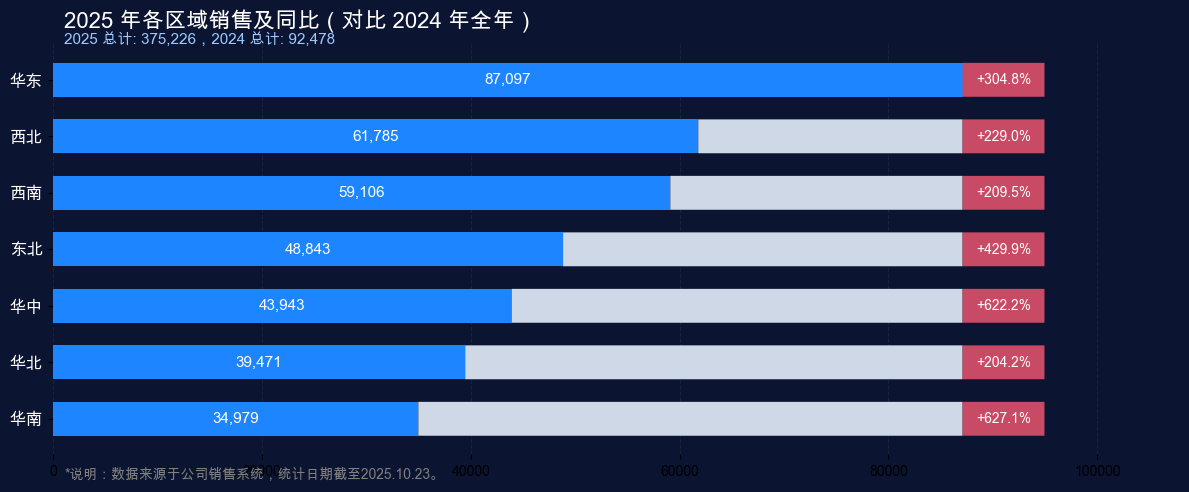

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, FancyBboxPatch
import pandas as pd

# 准备数据：按年度汇总（优先使用 paid_amount，否则使用 quantity 或 product_amount）
df['payment_date'] = pd.to_datetime(df['payment_date'], errors='coerce')
df_time = df.dropna(subset=['payment_date']).copy()

# 判定使用的金额字段
if 'paid_amount' in df_time.columns:
    amount_col = 'paid_amount'
elif 'product_amount' in df_time.columns:
    amount_col = 'product_amount'
elif {'unit_price', 'quantity'}.issubset(df_time.columns):
    df_time['product_amount_calc'] = df_time['unit_price'] * df_time['quantity']
    amount_col = 'product_amount_calc'
else:
    # 回退到数量作为指标（提醒用户）
    amount_col = 'quantity'

# 汇总 2025 与 2024 全年（按 region）
df_2025 = df_time[df_time['payment_date'].dt.year == 2025].copy()
df_2024 = df_time[df_time['payment_date'].dt.year == 2024].copy()

# 确保存在 region 列（若不存在，尝试用 province 映射）
if 'region' not in df_2025.columns:
    if 'province' in df_2025.columns:
        df_2025['region'] = df_2025['province'].map(region_mapping).fillna('其他')
    else:
        df_2025['region'] = '其他'
if 'region' not in df_2024.columns:
    if 'province' in df_2024.columns:
        df_2024['region'] = df_2024['province'].map(region_mapping).fillna('其他')
    else:
        df_2024['region'] = '其他'

agg_2025 = df_2025.groupby('region', as_index=True)[amount_col].sum().rename('sales_2025')
agg_2024 = df_2024.groupby('region', as_index=True)[amount_col].sum().rename('sales_2024')

comp = pd.concat([agg_2025, agg_2024], axis=1).fillna(0)
comp = comp.sort_values('sales_2025', ascending=False)
if comp.empty:
    raise ValueError('未找到 2025 或 2024 的数据用于汇总，请检查 payment_date 与金额/数量字段。')

regions = comp.index.tolist()
sales_2025 = comp['sales_2025'].values.astype(float)
sales_2024 = comp['sales_2024'].values.astype(float)

# 计算同比（%）
with np.errstate(divide='ignore', invalid='ignore'):
    yoy_pct = np.where(sales_2024 > 0, (sales_2025 - sales_2024) / sales_2024 * 100.0, np.nan)

# 绘图（深色主题，水平柱状，右侧显示占位格：浅灰销量占位格 + 固定宽度红色涨幅占位格）
bg = '#0b1430'
bar_color = '#1c85ff'
y = np.arange(len(regions))
fig, ax = plt.subplots(figsize=(12, max(5, len(regions)*0.5)))
fig.patch.set_facecolor(bg)
ax.set_facecolor(bg)

max_val = max(sales_2025.max() if len(sales_2025)>0 else 0, 1)
# 统一条与占位格的高度基准，避免粗细不一致
bar_h = 0.6
bars = ax.barh(y, sales_2025, color=bar_color, height=bar_h, zorder=3)

# 标注数值：当条宽度足够时，将销量放在蓝色条内部居中显示，否则放在条右侧
text_inside_threshold = max_val * 0.08
for yi, val, pct in zip(y, sales_2025, yoy_pct):
    if val >= text_inside_threshold:
        # 放条中间
        ax.text(val/2, yi, f'{int(val):,d}', va='center', ha='center', color='white', fontsize=11, fontweight='bold')
    else:
        # 条太窄则放在右侧
        ax.text(val + max_val*0.01, yi, f'{int(val):,d}', va='center', ha='left', color='white', fontsize=11, fontweight='bold')

# 预留右侧区域用于占位格：扩展 xlim（基于当前数据范围按比例扩展）
left_limit, right_limit = ax.get_xlim()
extra_frac = 0.18  # 给占位格留出的额外宽度比例（稍微增大以容纳更宽的红格）
ax.set_xlim(left_limit, right_limit + (right_limit - left_limit) * extra_frac)
x_min, x_max = ax.get_xlim()

# 占位格参数（基于数据坐标）
# 使用与蓝色条相同的高度基准以保证粗细一致
box_h = bar_h
box_pad = max_val * 0.02
# 使用与蓝色条（数据单位）一致的宽度基准：基于 max_val
box_w_min = max_val * 0.02
# 红色占位格宽度以蓝色基准为参考（数据单位）
box_w_fixed = max_val * 0.09
# 移除与条之间的偏移，使格子紧贴条尾
box1_start_offset = 0.0
box2_start_offset = 0.0

# 为所有行绘制右侧涨幅占位格；为非最大销量行绘制浅灰补齐格（宽度按 87097-销量），最大行不绘制浅灰格以避免重复显示
max_idx = 0
if len(sales_2025) > 0:
    try:
        max_idx = int(np.nanargmax(sales_2025))
    except Exception:
        max_idx = 0
for i, yi in enumerate(y):
    val = float(sales_2025[i]) if i < len(sales_2025) else 0.0
    # 计算浅灰格宽度：以蓝色条的基准 max_val 为顶线，补齐到 max_val 的差值（数据单位）
    gray_width = max(0.0, max_val - val)
    # 保证灰格至少有最小宽度以便可视化
    if gray_width > 0:
        gray_width = max(gray_width, box_w_min)
    else:
        gray_width = 0.0

    # 灰色补齐格从条尾开始绘制（无中间间隙）
    if i != max_idx and gray_width > 0:
        b1_left = val + box1_start_offset
        b1 = FancyBboxPatch((b1_left, yi - box_h/2), gray_width, box_h,
                            boxstyle='round,pad=0,rounding_size={}'.format(box_h/2),
                            linewidth=0, facecolor='#cfd8e6', edgecolor='none', zorder=6)
        ax.add_patch(b1)

    # 每行都绘制固定宽度的红色涨幅占位格（紧贴灰格或条尾），并将文本居中
    red_left = val + box2_start_offset + (gray_width if (i != max_idx and gray_width>0) else 0.0)
    b2 = FancyBboxPatch((red_left, yi - box_h/2), box_w_fixed, box_h,
                        boxstyle='round,pad=0,rounding_size={}'.format(box_h/2),
                        linewidth=0, facecolor='#c94a64', edgecolor='none', zorder=6)
    ax.add_patch(b2)
    # 红色格显示同比涨幅（百分比），若无历史数据则显示 '-'
    growth = yoy_pct[i] if i < len(yoy_pct) else np.nan
    if np.isfinite(growth):
        growth_str = f'{growth:+.1f}%'
    else:
        growth_str = '-'
    ax.text(red_left + box_w_fixed/2, yi, growth_str, ha='center', va='center', color='white', fontsize=10, fontweight='bold', zorder=7)

# y 轴与样式调整
ax.set_yticks(y)
ax.set_yticklabels(regions, fontsize=12, color='white')
ax.invert_yaxis()
ax.xaxis.grid(True, linestyle='--', color='#23344f', alpha=0.5)
for s in ax.spines.values():
    s.set_visible(False)

# 标题与注释
total_2025 = int(sales_2025.sum())
total_2024 = int(sales_2024.sum())
ax.text(0.01, 1.04, '2025 年各区域销售及同比（对比 2024 年全年）', transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left', color='white')
ax.text(0.01, 1.00, f'2025 总计: {total_2025:,d}，2024 总计: {total_2024:,d}', transform=ax.transAxes, fontsize=11, ha='left', color='#9cc9ff')
note = '*说明：数据来源于公司销售系统，统计日期截至2025.10.23。'
ax.text(0.01, -0.06, note, transform=ax.transAxes, fontsize=10, ha='left', color='gray')

plt.tight_layout()
plt.show()